# Epymorph dev log: June 26th, 2023

_author: Tyler Coles_

_as of git hash: 034c9b3c7c3c74db9892f49199b3f3511f137e1b_

## The Pei Model

To demonstrate the specification of an IPM using epymorph's new CompartmentModel system, let's re-implement the Pei SIRS model. To recap: this model uses a beta value that varies over time in response to local humidity.

For reference, here's the transition diagram:

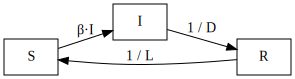

In [5]:
import pydot
from IPython.core.display import SVG

diagram_dot = """digraph {
    rankdir=LR;
    node [shape=box];
    S -> I [label="&beta;&middot;I"];
    I -> R [label="1 / D"];
    R -> S [label="1 / L"]
}"""
diagram = pydot.graph_from_dot_data(diagram_dot)[0]  # type: ignore
SVG(data=diagram.create_svg())


Where L is the average period of immunity and D is the mean infectious period.

And the beta equation:

In [6]:
from sympy import Equality, exp, log, symbols

beta, a, r0max, r0min, D, H = symbols('beta_t a R_0_max R_0_min D H_t')
beta_expr = (exp(a * H + log(r0max - r0min), evaluate=False) + r0min) / D
Equality(beta, beta_expr)


Eq(beta_t, (R_0_min + exp(H_t*a + log(R_0_max - R_0_min)))/D)

## Specifying the IPM

Now we get into epymorph specifics. There are two steps in using the CompartmentModel system.

1. Declare and extract symbols representing the model compartments and required geo/parameter attributes.
2. Use the symbols to define the model transitions and the rate equations for each transition.

In [7]:
from sympy import exp

from epymorph.ipm.attribute import geo, param
from epymorph.ipm.compartment_ipm import (CompartmentModel,
                                          CompartmentModelIpmBuilder)
from epymorph.ipm.compartment_model import (create_model, create_symbols, edge,
                                            quick_compartments)

# We have compartments S, I, and R;
# and attributes D, L,(from the simulation parameters) and H (from the geo).
symbols = create_symbols(
    compartments=quick_compartments('S I R'),
    attributes=[
        # Attribute constructor functions take arguments for:
        # 1. the symbol name,
        # 2. its name in the parameters dictionary (if different from #1),
        # 3. a shape description (which defaults to scalar)
        # 4. a data type (which defaults to Python float)
        param('D', 'infection_duration'),
        param('L', 'immunity_duration'),
        geo('H', 'humidity', shape='TxN'),
    ])

# Extract the symbols so we can use sympy math operators to build equations.
[S, I, R] = symbols.compartment_symbols
[D, L, H] = symbols.attribute_symbols

# For the sake of readability and re-use, we can define expressions as needed.
# Here's our beta function, filling in known constants.
# (Although we certainly could have decided to make these constants parameters as well.)
beta = (0.7 * exp(-180 * H) + 1.3) / D

# And now we can define our model by:
# 1. providing the symbols we just declared, and
# 2. specifying the transition edges and their associated rate equations.
pei: CompartmentModel = create_model(
    symbols=symbols,
    transitions=[
        # The edge constructor takes arguments for:
        # 1. the source compartment,
        # 2. the destination compartment,
        # 3. the rate equation as a sympy Expression
        edge(S, I, rate=beta * S * I / (S + I + R)),
        edge(I, R, rate=I / D),
        edge(R, S, rate=R / L)
    ])


## Running the simulation

Now that we have a CompartmentModel defined, we can wrap that with a CompartmentModelIpmBuilder and pass it to the Simulation constructor. This part is basically the same as running a simulation with any of the previously developed IPMs.

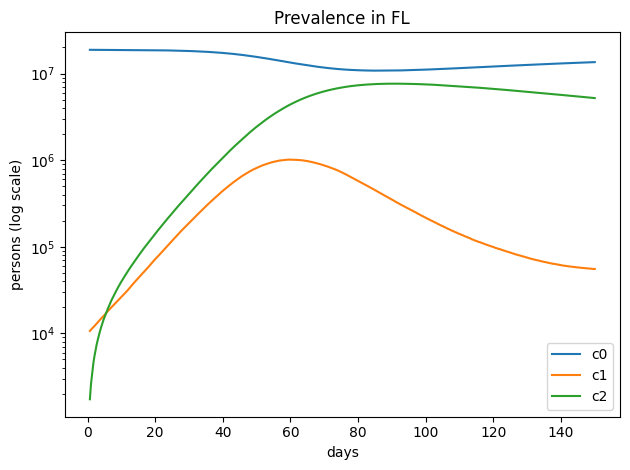

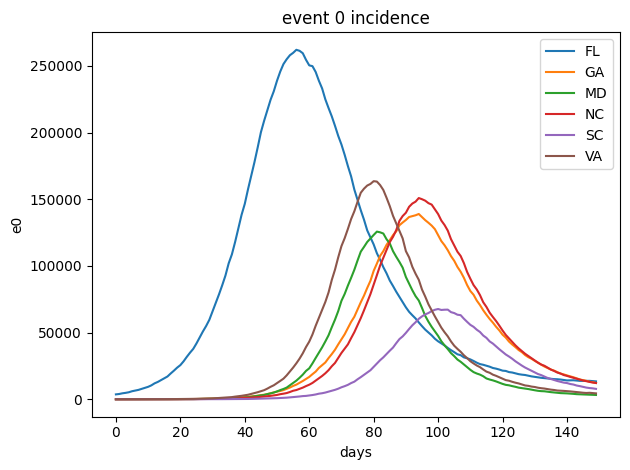

In [8]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=CompartmentModelIpmBuilder(pei),
    mvm_builder=mm_library['pei']())

out = sim.run(
    param={
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
        'infection_seed_loc': 0,
        'infection_seed_size': 10_000
    },
    start_date=date(2015, 1, 1),
    duration_days=150
)

plot_pop(out, 0)
plot_event(out, 0)
